In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews/Restaurant_Reviews.tsv


**1. Text Preprocessing**

**2. Text Visualization**

**3. Sentiment Analysis**

**4. Sentiment Modeling**


In [2]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
df = pd.read_csv("../input/reviews/Restaurant_Reviews.tsv",delimiter="\t")

> **1. Text Preprocessing**

In [5]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
df.shape

(1000, 2)

***Normalizing Case Folding***

In [8]:
df['Review'] = df['Review'].str.lower()

In [9]:
df.head()

,Review,Liked
0,wow... loved this place.,1
1,crust is not good.,0
2,not tasty and the texture was just nasty.,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


***Punctuations***

In [10]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [11]:
df['Review'] = df['Review'].str.replace('\d', '')

***Stopwords*** 

It allows us to get rid of commonly used words.

In [12]:
sw = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

***Rarewords***

We drop words according to their frequencies.

In [13]:
drops = pd.Series(' '.join(df['Review']).split()).value_counts()[-250:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

***Tokenization***

break sentences into parts

In [14]:
df["Review"].apply(lambda x: TextBlob(x).words).head()

0                                  [wow, loved, place]
1                                        [crust, good]
2                              [tasty, texture, nasty]
3    [stopped, late, may, bank, holiday, rick, reco...
4                     [selection, menu, great, prices]
Name: Review, dtype: object

***Lemmatization / Stemming***

is the process of separating words by root

In [15]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [16]:
df["Review"].head()

0                                      wow loved place
1                                           crust good
2                                  tasty texture nasty
3    stopped late may bank holiday rick recommendat...
4                           selection menu great price
Name: Review, dtype: object

> **2. Text Visualization**

Calculate the term frequencies

In [17]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [18]:
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,loved,10.00
1,wow,3.00
2,place,111.00
3,crust,2.00
4,good,95.00


In [19]:
tf.shape

(1591, 2)

In [20]:
tf["words"].nunique()

1591

In [21]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   1591.00
mean       3.38
std        7.15
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        3.00
80%        4.00
90%        7.00
95%       12.00
99%       27.00
max      124.00
Name: tf, dtype: float64

In [22]:
tf.sort_values("tf", ascending = False)

,words,tf
76,food,124.00
2,place,111.00
4,good,95.00
40,service,83.00
16,great,70.00
...,...,...
896,handling,1.00
897,rowdy,1.00
903,rest,1.00
904,ache,1.00


Barplot

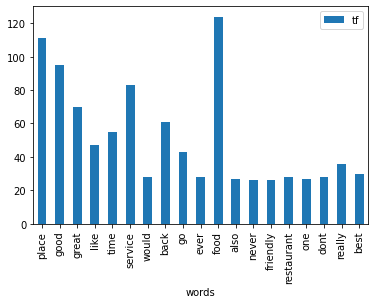

In [23]:
tf[tf["tf"] > 25].plot.bar(x="words", y="tf")
plt.show()

Wordcloud

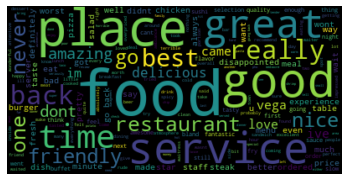

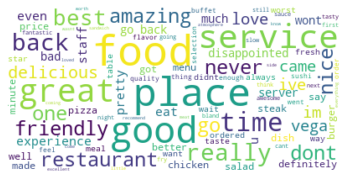

In [24]:
text = " ".join(i for i in df.Review)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

> **3. Sentiment Analysis**

In [25]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The food was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [26]:
df["Review"].apply(lambda x: x.upper())

0                                        WOW LOVED PLACE
1                                             CRUST GOOD
2                                    TASTY TEXTURE NASTY
3      STOPPED LATE MAY BANK HOLIDAY RICK RECOMMENDAT...
4                             SELECTION MENU GREAT PRICE
                             ...                        
995                    THINK FOOD FLAVOR TEXTURE LACKING
996                              APPETITE INSTANTLY GONE
997                      OVERALL IMPRESSED WOULD GO BACK
998    WHOLE EXPERIENCE UNDERWHELMING THINK WELL GO S...
999    WASTED ENOUGH LIFE POURED SALT WOUND DRAWING T...
Name: Review, Length: 1000, dtype: object

In [27]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.115, 'pos': 0.885, 'comp...
1    {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...
2    {'neg': 0.643, 'neu': 0.357, 'pos': 0.0, 'comp...
3    {'neg': 0.141, 'neu': 0.37, 'pos': 0.489, 'com...
4    {'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'comp...
5    {'neg': 0.645, 'neu': 0.215, 'pos': 0.14, 'com...
6    {'neg': 0.395, 'neu': 0.605, 'pos': 0.0, 'comp...
7    {'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'comp...
8    {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...
9    {'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'comp...
Name: Review, dtype: object

In [28]:
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [29]:
df.head()

,Review,Liked,polarity_score
0,wow loved place,1,0.83
1,crust good,0,0.44
2,tasty texture nasty,0,-0.56
3,stopped late may bank holiday rick recommendat...,1,0.69
4,selection menu great price,1,0.62


> **4. Sentiment Modeling**

Create the target

In [30]:
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    neg
3    pos
4    pos
5    neg
6    neg
7    pos
8    pos
9    pos
Name: Review, dtype: object

Apply for all data

In [31]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(20)

,Review,Liked,polarity_score,sentiment_label
0,wow loved place,1,0.83,pos
1,crust good,0,0.44,pos
2,tasty texture nasty,0,-0.56,neg
3,stopped late may bank holiday rick recommendat...,1,0.69,pos
4,selection menu great price,1,0.62,pos
5,getting angry want damn pho,0,-0.69,neg
6,honeslty didnt taste fresh,0,-0.24,neg
7,potato like rubber could tell made time kept w...,0,0.57,pos
8,fry great,1,0.62,pos
9,great touch,1,0.62,pos


In [32]:
df.groupby("sentiment_label")["Liked"].mean()

sentiment_label
neg   0.22
pos   0.75
Name: Liked, dtype: float64

In [33]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [34]:
X = df["Review"]
y = df["sentiment_label"]

***Count Vectors***

converts text to a term count vector.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(X)

vectorizer.get_feature_names()[10:15]
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

***TF-IDF***

It is the weight factor calculated with the statistical method that shows the importance of a term in the document.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [37]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_word_vectorizer.fit_transform(X)

***Logistic Regression***

In [38]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model,
                X_tf_idf_word,
                y, scoring="accuracy",
                cv=5).mean()

0.813

In [39]:
random_review = pd.Series(df["Review"].sample(1).values)
random_review

0    great food price high quality house made
dtype: object

In [40]:
new_comment = CountVectorizer().fit(X).transform(random_review)
log_model.predict(new_comment)

array([1])

***Random Forests***

In [41]:
rf_model = RandomForestClassifier().fit(X_count, y)
print(cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean())

0.8319999999999999


*TF-IDF Word-Level*

In [42]:
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
print(cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean())

0.8059999999999998


In [43]:
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
print(cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean())

0.8089999999999999


**Hyperparameter Optimization**

In [44]:
rf_model = RandomForestClassifier(random_state=17)

rf_params = {"max_depth": [5, 8, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 5, 8, 20],
             "n_estimators": [100, 200, 500]}

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_count, y)

rf_best_grid.best_params_

rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

cv_results = cross_validate(rf_final, X_count, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  2.9min finished


0.9004796656164906